In [38]:
import os
import sys

# Get the current working directory
current_dir = os.getcwd()
# Add the ./src folder to the Python module search path
sys.path.append(os.path.join(current_dir, '..', 'src'))

from train_test import *
from utils import *
from optimize import *

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.cluster import KMeans
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline


from scipy import stats
from scipy.optimize import minimize
from scipy.stats import pearsonr
from scipy.stats import ks_2samp


import xgboost as xgb


sns.set_style('ticks')

### 1. read sparse and dense best feature sets

In [39]:
input_path = '../Data/'

features_file_1 = 'featureSelection/selection_cleanMordredDescriptors.csv'
features_file_2 =  'deepnose_features.npy'
CID_file = 'molecules_train_cid.npy'

# Read all copies, before and after correction; before was also downloaded from Dropbox.
mixture_file = 'Mixure_Definitions_Training_set_UPD2.csv' 
training_task_file = 'TrainingData_mixturedist.csv'

# Mordred features
features_1 = pd.read_csv(os.path.join(input_path, features_file_1), index_col= 0)

features_2 = np.load(os.path.join(input_path, features_file_2))

features_CIDs = np.load(os.path.join(input_path, CID_file))
# Training dataframe
training_set = pd.read_csv(os.path.join(input_path, training_task_file))

# Mapping helper files
mixtures_IDs = pd.read_csv(os.path.join(input_path, mixture_file))


feature_file_3 = 'Fingerprints/Morgan_Fingerprints_Frequency_Size50.csv'
features_3 = pd.read_csv(os.path.join(input_path, feature_file_3), index_col= 0)
features_file_4 =  'leffingwell_features_96.npy'
features_4 = np.load(os.path.join(input_path, features_file_4))

In [40]:
scaler = StandardScaler(with_mean=True, with_std=True)

# standardize Mordred
features_1_np = scaler.fit_transform(features_1)
features_1 = pd.DataFrame(features_1_np, columns=features_1.columns, index=features_1.index)


# log standardize deepnose
scaler = StandardScaler(with_mean=True, with_std=True)
epsilon = 1e-8 
features_2 = scaler.fit_transform(np.log(features_2 + epsilon))

In [41]:
# Double check the number of unique non-NaN values in each feature column
num_unique_values = np.count_nonzero(~np.isnan(features_1), axis=0)

# Print if the number of unique non-NaN values for each feature
for i, count in enumerate(num_unique_values):
    if count == 0:
        print(f"Feature {i}: {count} unique non-NaN values")

In [42]:
# Map CID to features:

# Dense
CID2features_deepnose=  {CID: features_2[i] for i, CID in enumerate(features_CIDs)}
CID2features_mordred =  {CID: features_1.loc[CID].tolist() for CID in features_CIDs}

CID2features_morgan =  {CID: features_3.loc[CID].tolist() for CID in features_CIDs}
CID2features_leffingwell = {CID: features_4[i] for i, CID in enumerate(features_CIDs)}

In [44]:
# Sparse
features_list = [CID2features_mordred, CID2features_deepnose]
features_list_sparse = [CID2features_morgan, CID2features_leffingwell]

X_dense, y_true = stacking_X_features(features_list, "avg")
X_sparse, _ = stacking_X_features(features_list_sparse, "sum")

X_dense_new, y_test_true = stacking_X_test_features(features_list,  X_dense, "avg")
X_sparse_new, _ = stacking_X_test_features(features_list_sparse,  X_sparse, "sum")

### 2. Training with sparse, dense and different meta models over sparse and dense predictions

In [45]:
n_folds = 10
seed = 314159

# This is obtained from training individual models:
best_rf_dense = {'n_estimators': 500, 'min_samples_split': 2, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': True}
best_rf_sparse = {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 0.5, 'max_depth': 30, 'bootstrap': True}

In [118]:
def evaluate_fold(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    corr, _ = pearsonr(y_true, y_pred)
    return rmse, corr

def stacking_ensemble_cv(X_dense, X_sparse, y, base_model_dense, base_model_sparse, meta_models, n_folds=100):
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=seed)
    
    dense_preds = np.zeros(len(y))
    sparse_preds = np.zeros(len(y))
    meta_preds = {name: np.zeros(len(y)) for name in meta_models.keys()}
    
    fold_results = {
        'dense_model': {'RMSE': [], 'Correlation': []},
        'sparse_model': {'RMSE': [], 'Correlation': []}
    }
    for name in meta_models.keys():
        fold_results[f'stacked_model_{name}'] = {'RMSE': [], 'Correlation': []}
    
    for train_index, val_index in kf.split(X_dense):
        X_dense_train, X_dense_val = X_dense[train_index], X_dense[val_index]
        X_sparse_train, X_sparse_val = X_sparse[train_index], X_sparse[val_index]
        y_train, y_val = y[train_index], y[val_index]
        
        # Train and predict with base models
        base_model_dense.fit(X_dense_train, y_train)
        base_model_sparse.fit(X_sparse_train, y_train)
        
        dense_preds[val_index] = base_model_dense.predict(X_dense_val)
        sparse_preds[val_index] = base_model_sparse.predict(X_sparse_val)
        
        # Evaluate base models for this fold
        rmse, corr = evaluate_fold(y_val, dense_preds[val_index])
        fold_results['dense_model']['RMSE'].append(rmse)
        fold_results['dense_model']['Correlation'].append(corr)
        
        rmse, corr = evaluate_fold(y_val, sparse_preds[val_index])
        fold_results['sparse_model']['RMSE'].append(rmse)
        fold_results['sparse_model']['Correlation'].append(corr)
        
        # Train and predict with meta models
        meta_features_train = np.column_stack((
            base_model_dense.predict(X_dense_train),
            base_model_sparse.predict(X_sparse_train)
        ))
        meta_features_val = np.column_stack((dense_preds[val_index], sparse_preds[val_index]))
        
        for name, meta_model in meta_models.items():
            meta_model.fit(meta_features_train, y_train)
            meta_preds[name][val_index] = meta_model.predict(meta_features_val)
            
            # Evaluate meta model for this fold
            rmse, corr = evaluate_fold(y_val, meta_preds[name][val_index])
            fold_results[f'stacked_model_{name}']['RMSE'].append(rmse)
            fold_results[f'stacked_model_{name}']['Correlation'].append(corr)
    
    # Calculate overall performance
    overall_results = {
        'dense_model': {'RMSE': np.sqrt(mean_squared_error(y, dense_preds)),
                        'Correlation': pearsonr(y, dense_preds)[0]},
        'sparse_model': {'RMSE': np.sqrt(mean_squared_error(y, sparse_preds)),
                         'Correlation': pearsonr(y, sparse_preds)[0]}
    }
    
    for name in meta_models.keys():
        overall_results[f'stacked_model_{name}'] = {
            'RMSE': np.sqrt(mean_squared_error(y, meta_preds[name])),
            'Correlation': pearsonr(y, meta_preds[name])[0]
        }
    
    return {'performance': overall_results, 'fold_results': fold_results}

def visualize_fold_results(fold_results):
    num_models = len(fold_results)
    fig, axes = plt.subplots(2, 1, figsize=(20, 8))
    
    for ax, metric in zip(axes, ['RMSE', 'Correlation']):
        for i, (model_name, results) in enumerate(fold_results.items()):
            values = results[metric]
            ax.plot(range(1, len(values) + 1), values, marker='o', label=model_name)
        
        ax.set_xlabel('Fold')
        ax.set_ylabel(metric)
        ax.set_title(f'{metric} across folds')
        ax.legend()
        ax.grid(True)
    
    plt.tight_layout()
    plt.show()

# Define base models
base_model_dense = RandomForestRegressor(**best_rf_dense, random_state=seed)
base_model_sparse = RandomForestRegressor(**best_rf_sparse, random_state=seed)

# Define meta models
meta_models = {
    'Ridge': Ridge(),
    'Poly_Ridge': make_pipeline(PolynomialFeatures(degree=2), Ridge()),
    'RF': RandomForestRegressor(random_state=seed),
    'GB': GradientBoostingRegressor(random_state=seed),
    'KNN': KNeighborsRegressor()
}

# Run cross-validation
cv_results = stacking_ensemble_cv(X_dense, X_sparse, y_true, base_model_dense, base_model_sparse, meta_models)

# Print overall results
print("Overall Cross-validation Performance:")
for model, performance in cv_results['performance'].items():
    print(f"{model}:")
    print(f"  RMSE: {performance['RMSE']:.4f}")
    print(f"  Correlation: {performance['Correlation']:.4f}")
    print()

Overall Cross-validation Performance:
dense_model:
  RMSE: 0.1210
  Correlation: 0.6514

sparse_model:
  RMSE: 0.1203
  Correlation: 0.6416

stacked_model_Ridge:
  RMSE: 0.1178
  Correlation: 0.6584

stacked_model_Poly_Ridge:
  RMSE: 0.1178
  Correlation: 0.6595

stacked_model_RF:
  RMSE: 0.1206
  Correlation: 0.6374

stacked_model_GB:
  RMSE: 0.1203
  Correlation: 0.6399

stacked_model_KNN:
  RMSE: 0.1191
  Correlation: 0.6490



In [119]:
def calculate_fold_means(fold_results):
    mean_results = {}
    for model, metrics in fold_results.items():
        mean_results[model] = {
            'Mean RMSE': np.mean(metrics['RMSE']),
            'Std RMSE': np.std(metrics['RMSE']),
            'Mean Correlation': np.mean(metrics['Correlation']),
            'Std Correlation': np.std(metrics['Correlation'])
        }
    return mean_results

def print_fold_means(mean_results):
    print("Mean Performance Across Folds:")
    for model, metrics in mean_results.items():
        print(f"\n{model}:")
        print(f"  RMSE: {metrics['Mean RMSE']:.4f} ± {metrics['Std RMSE']:.4f}")
        print(f"  Correlation: {metrics['Mean Correlation']:.4f} ± {metrics['Std Correlation']:.4f}")

# Print and visualize per fold performance as well
fold_means = calculate_fold_means(cv_results['fold_results'])
print_fold_means(fold_means)

Mean Performance Across Folds:

dense_model:
  RMSE: 0.1129 ± 0.0436
  Correlation: 0.6609 ± 0.3242

sparse_model:
  RMSE: 0.1117 ± 0.0445
  Correlation: 0.6385 ± 0.3444

stacked_model_Ridge:
  RMSE: 0.1090 ± 0.0447
  Correlation: 0.6610 ± 0.3264

stacked_model_Poly_Ridge:
  RMSE: 0.1090 ± 0.0447
  Correlation: 0.6630 ± 0.3257

stacked_model_RF:
  RMSE: 0.1116 ± 0.0458
  Correlation: 0.6409 ± 0.3483

stacked_model_GB:
  RMSE: 0.1112 ± 0.0460
  Correlation: 0.6435 ± 0.3459

stacked_model_KNN:
  RMSE: 0.1101 ± 0.0453
  Correlation: 0.6542 ± 0.3290


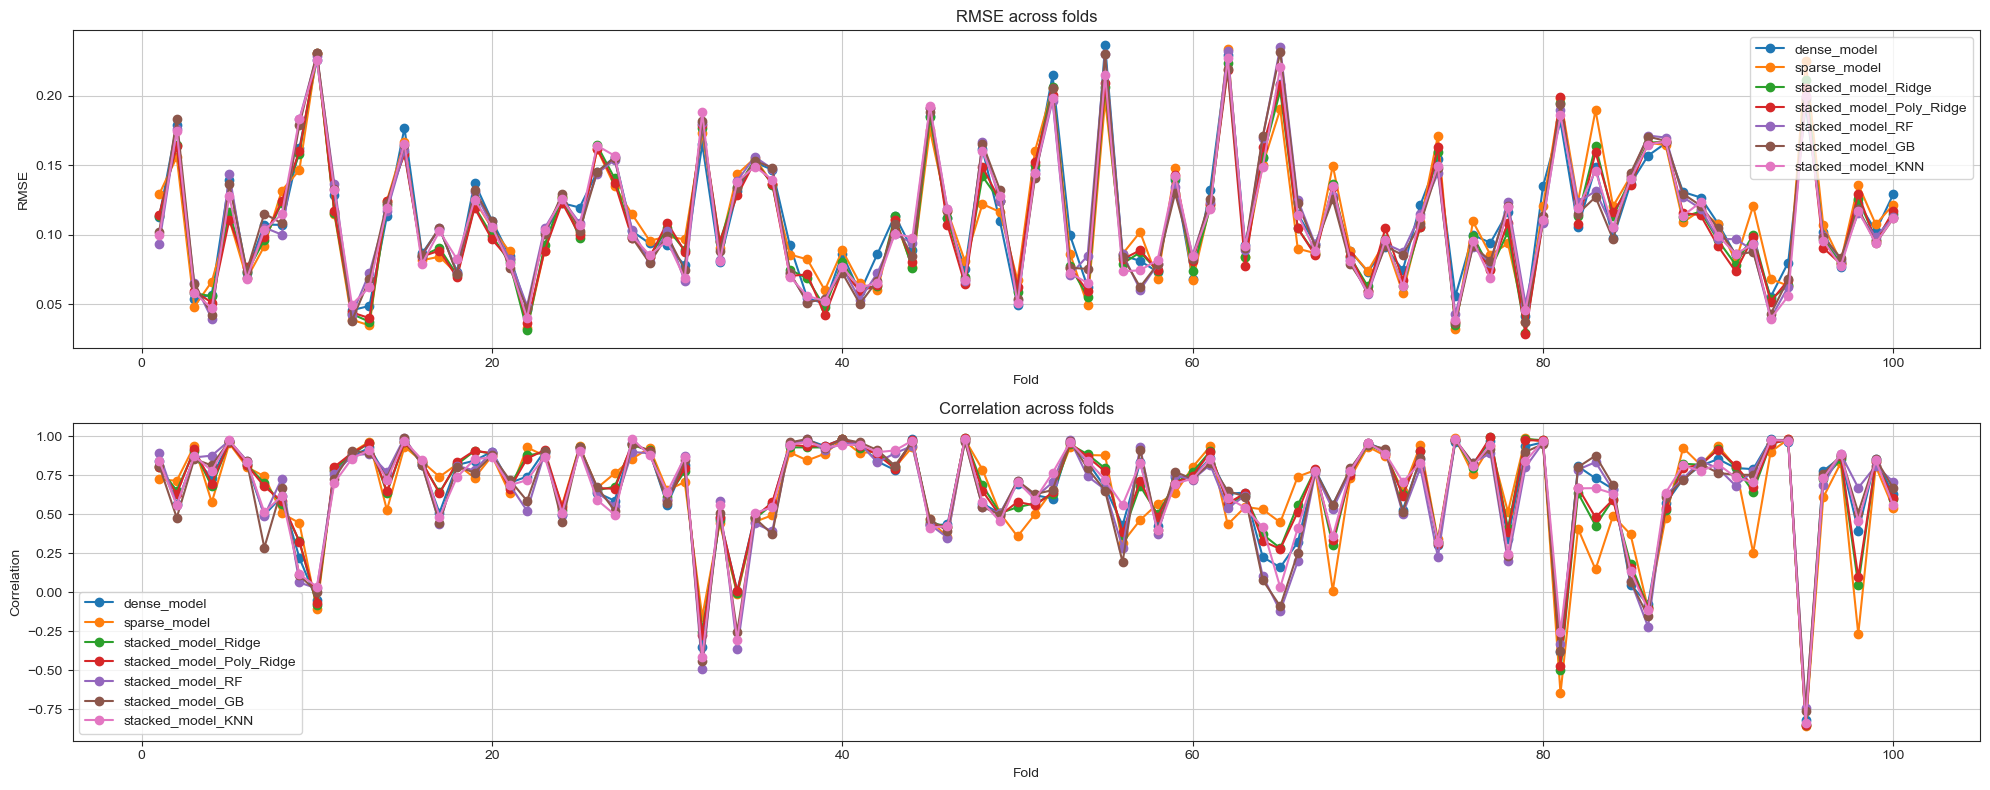

In [120]:
# Visualize fold results
visualize_fold_results(cv_results['fold_results'])

### Train final model

In [131]:
def train_final_models(X_dense, X_sparse, y, base_model_dense_class, base_model_sparse_class, meta_models, n_models=1):
    final_models = {name: [] for name in meta_models.keys()}
    
    for seed in range(n_models):
        base_model_dense = base_model_dense_class(**best_rf_dense, random_state=seed)
        base_model_sparse = base_model_sparse_class(**best_rf_sparse, random_state=seed)
        
        # Train base models
        final_base_model_dense = base_model_dense.fit(X_dense, y)
        final_base_model_sparse = base_model_sparse.fit(X_sparse, y)
        
        # Train meta models
        final_meta_features = np.column_stack((
            final_base_model_dense.predict(X_dense),
            final_base_model_sparse.predict(X_sparse)
        ))
        
        for name, meta_model_class in meta_models.items():
            if name == 'Poly_Ridge':
                meta_model = meta_model_class.fit(final_meta_features, y)
            elif name == 'KNN':
                meta_model = meta_model_class().fit(final_meta_features, y)
            else:
                meta_model = meta_model_class(random_state=seed).fit(final_meta_features, y)
            final_models[name].append((final_base_model_dense, final_base_model_sparse, meta_model))
    
    return final_models

def predict_stacked_ensemble(X_dense_new, X_sparse_new, final_models):
    predictions = {name: [] for name in final_models.keys()}
    
    for name, models in final_models.items():
        for dense_model, sparse_model, meta_model in models:
            dense_pred = dense_model.predict(X_dense_new)
            sparse_pred = sparse_model.predict(X_sparse_new)
            meta_features = np.column_stack((dense_pred, sparse_pred))
            meta_pred = meta_model.predict(meta_features)
            predictions[name].append(meta_pred)
    
    return {name: np.mean(preds, axis=0) for name, preds in predictions.items()}

def evaluate_performance(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    corr, _ = pearsonr(y_true, y_pred)
    return rmse, corr

# Define meta-models, a bit different from cv, as here random state and other argument are specified within the loop
meta_models = {
    'Ridge': Ridge,
    'Poly_Ridge': make_pipeline(PolynomialFeatures(degree=2), Ridge()),
    'RF': RandomForestRegressor,
    'GB': GradientBoostingRegressor,
    'KNN': KNeighborsRegressor
}

In [136]:
np.random.seed(30)
# Generate indices for the random subset
all_indices = np.arange(len(y_true))
subset_indices = resample(all_indices, n_samples=450, replace=False)

# Create the subsets for training (450 samples)
X_dense_450 = X_dense[subset_indices]
X_sparse_450 = X_sparse[subset_indices]
y_true_450 = y_true[subset_indices]

# Create the subsets for the fake test set (remaining 50 samples)
fake_test_indices = np.setdiff1d(all_indices, subset_indices)
X_dense_50 = X_dense[fake_test_indices]
X_sparse_50 = X_sparse[fake_test_indices]
y_true_50 = y_true[fake_test_indices]

In [137]:
# Train models on 450 random samples
final_models_450 = train_final_models(X_dense_450, X_sparse_450, y_true_450, RandomForestRegressor, RandomForestRegressor, meta_models)

# Evaluate on training data
train_predictions_450 = predict_stacked_ensemble(X_dense_450, X_sparse_450, final_models)

print("450 data only Training Set Performance:")
print()
for name, preds in train_predictions_450.items():
    rmse, corr = evaluate_performance(y_true_450, preds)
    print(f"{name} - RMSE: {rmse:.4f}, Correlation: {corr:.4f}")

print()
print("\nTest Set Performance, leaderboard:")
print()
# Evaluate on test data
test_predictions_450_new = predict_stacked_ensemble(X_dense_new, X_sparse_new, final_models_450)

for name, preds in test_predictions_450_new.items():
    rmse, corr = evaluate_performance(y_test_true, preds)
    print(f"{name} - RMSE: {rmse:.4f}, Correlation: {corr:.4f}")

print("\nTest Set Performance, 50 not selected training:")
print()
# Evaluate on test data
test_predictions_450_50 = predict_stacked_ensemble(X_dense_50, X_sparse_50, final_models_450)

for name, preds in test_predictions_450_50.items():
    rmse, corr = evaluate_performance(y_true_50, preds)
    print(f"{name} - RMSE: {rmse:.4f}, Correlation: {corr:.4f}")

450 data only Training Set Performance:

Ridge - RMSE: 0.0349, Correlation: 0.9770
Poly_Ridge - RMSE: 0.0352, Correlation: 0.9747
RF - RMSE: 0.0117, Correlation: 0.9973
GB - RMSE: 0.0198, Correlation: 0.9920
KNN - RMSE: 0.0256, Correlation: 0.9867


Test Set Performance, leaderboard:

Ridge - RMSE: 0.1165, Correlation: 0.7144
Poly_Ridge - RMSE: 0.1180, Correlation: 0.7104
RF - RMSE: 0.1166, Correlation: 0.7183
GB - RMSE: 0.1173, Correlation: 0.7161
KNN - RMSE: 0.1164, Correlation: 0.7161

Test Set Performance, 50 not selected training:

Ridge - RMSE: 0.1208, Correlation: 0.6183
Poly_Ridge - RMSE: 0.1219, Correlation: 0.6156
RF - RMSE: 0.1238, Correlation: 0.5929
GB - RMSE: 0.1235, Correlation: 0.5953
KNN - RMSE: 0.1210, Correlation: 0.6154


In [140]:
# Train final models
final_models = train_final_models(X_dense, X_sparse, y_true, RandomForestRegressor, RandomForestRegressor, meta_models)

# Evaluate on training data
train_predictions = predict_stacked_ensemble(X_dense, X_sparse, final_models)

print("Training Set Performance:")
print()
for name, preds in train_predictions.items():
    rmse, corr = evaluate_performance(y_true, preds)
    print(f"{name} - RMSE: {rmse:.4f}, Correlation: {corr:.4f}")

Training Set Performance:

Ridge - RMSE: 0.0350, Correlation: 0.9769
Poly_Ridge - RMSE: 0.0352, Correlation: 0.9747
RF - RMSE: 0.0118, Correlation: 0.9972
GB - RMSE: 0.0202, Correlation: 0.9917
KNN - RMSE: 0.0255, Correlation: 0.9868


In [141]:
print("\nTest Set Performance:")
print()
# Evaluate on test data
test_predictions = predict_stacked_ensemble(X_dense_new, X_sparse_new, final_models)

for name, preds in test_predictions.items():
    rmse, corr = evaluate_performance(y_test_true, preds)
    print(f"{name} - RMSE: {rmse:.4f}, Correlation: {corr:.4f}")


Test Set Performance:



Ridge - RMSE: 0.1152, Correlation: 0.7156
Poly_Ridge - RMSE: 0.1168, Correlation: 0.7099
RF - RMSE: 0.1139, Correlation: 0.7270
GB - RMSE: 0.1138, Correlation: 0.7250
KNN - RMSE: 0.1163, Correlation: 0.7081


----

### Leaderboard and Training data diagnosis:

Trying to see if there's anything wrong with leaderboard being close to any training data point.

In [126]:
# Combine features of training and leaderboard data
X_train_combined = np.column_stack((X_dense, X_sparse))
X_leaderboard_combined = np.column_stack((X_dense_new, X_sparse_new))

In [127]:
X_train_combined.shape

(500, 652)

In [128]:
X_leaderboard_combined.shape

(46, 652)

In [129]:
def nearest_neighbor_distance(X, Y=None):
    if Y is None:
        distances = euclidean_distances(X)
        # Fill diagonal with inf to ignore self-distances
        np.fill_diagonal(distances, np.inf)
    else:
        distances = euclidean_distances(X, Y)
    return np.min(distances, axis=1)

# Calculate distances
train_to_train = nearest_neighbor_distance(X_train_combined)
leaderboard_to_train = nearest_neighbor_distance(X_leaderboard_combined, X_train_combined)

print("Avg distance within training (excluding self):", np.mean(train_to_train))
print("Avg distance leaderboard to training:", np.mean(leaderboard_to_train))


Avg distance within training (excluding self): 22.39618464200558
Avg distance leaderboard to training: 21.765200677869135


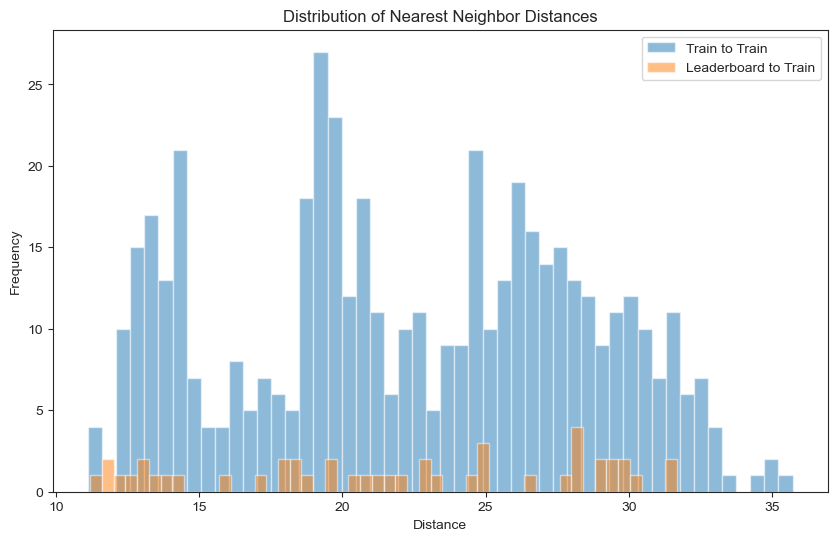

In [130]:
# Look at the distribution of these distances

plt.figure(figsize=(10, 6))
plt.hist(train_to_train, bins=50, alpha=0.5, label='Train to Train')
plt.hist(leaderboard_to_train, bins=50, alpha=0.5, label='Leaderboard to Train')
plt.legend()
plt.title('Distribution of Nearest Neighbor Distances')
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.show()

It seems that the leaderboard distribution of nearest neightbor distances follows training set very well.